## 4chan Sample Thread Exploration

This notebook contains the cleaning and exploration of the chan_example csv which is hosted on the far-right s3 bucket.  It contains cleaning out the html links from the text of the messages with beautiful soup, grouping the messages into their threads, and an exploratory sentiment analysis.

Further work could be to get the topic modelling for messages working and perhaps look at sentiment regarding different topics.

In [15]:
import boto3
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [16]:
session = boto3.Session(profile_name='default')
s3 = session.resource('s3')
bucket = s3.Bucket("far-right")
session.available_profiles

['default']

In [ ]:
# print all objects in bucket
for obj in bucket.objects.all():
    if "chan" in obj.key:
        #print(obj.key)
        pass

In [18]:
bucket.download_file('fourchan/chan_example.csv', 'chan_example.csv')

In [19]:
chan = pd.read_csv("chan_example.csv")
# remove the newline tags.  They're not useful for our analysis and just clutter the text.
chan.com = chan.com.astype(str).apply(lambda x: x.replace("<br>", " "))

In [20]:
bucket.download_file('info-source/daily/20170228/fourchan/fourchan_1204.json', '2017-02-28-1204.json')
chan2 = pd.read_json("2017-02-28-1204.json")

In [21]:
soup = BeautifulSoup(chan.com[19], "lxml")
quotes = soup.find("span")
for quote in quotes.contents:
    print(quote.replace(">>", ""))
parent = soup.find("a")
print(parent.contents[0].replace(">>", ""))

Simon is registered, certified and licensed for any action he deems necessary to "achieve the objective"
114878658


In [22]:
print(chan.com[19])

<a href="#p114878658" class="quotelink">&gt;&gt;114878658</a> On the &quot;About&quot; page  <span class="quote">&gt;&gt;Simon is registered, certified and licensed for any action he deems necessary to &quot;achieve the objective&quot;</span> The quoted text above hyperlinks to this video https://www.youtube.com/watch?v=y-Y<wbr>szp3SmxE  holy shit this guy


In [23]:
# If there's a quote and then the text, this would work. 
print(chan.com[19].split("</span>")[-1])

 The quoted text above hyperlinks to this video https://www.youtube.com/watch?v=y-Y<wbr>szp3SmxE  holy shit this guy


In [24]:
def split_comment(comment):
    """Splits up a comment into parent, quotes, and text"""
    
    # I used lxml to 
    soup = BeautifulSoup(comment, "lxml")
    quotes, quotelink, text = None, None, None
    try:
        quotes = soup.find("span")
        quotes = [quote.replace(">>", "") for quote in quotes.contents]
    except:
        pass
    try:
        quotelink = soup.find("a").contents[0].replace(">>", "")
    except: 
        pass
    # no quote or parent
    if quotes is None and quotelink is None:
        text = comment
    # Parent but no quote
    if quotelink is not None and quotes is None:
        text = comment.split("a>")[-1]
    # There is a quote
    if quotes is not None:
        text = comment.split("</span>")[-1]
    return {'quotes':quotes, 'quotelink': quotelink, 'text': text}

In [25]:
df = pd.DataFrame({'quotes':[], 'quotelink':[], 'text':[]})
for comment in chan['com']:
    df = df.append(split_comment(comment), ignore_index = True)
    
full = pd.merge(chan, df, left_index = True, right_index = True)

In [26]:
quotes = pd.Series()
quotelinks = pd.Series()
texts = pd.Series()
for comment in chan['com']:
    parse = split_comment(comment)
    quotes.append(pd.Series(parse['quotes']))
    quotelinks.append(pd.Series(parse['quotelink']))
    texts.append(pd.Series(parse['text']))
chan['quotes'] = quotes
chan['quotelinks'] = quotelinks
chan['text'] = texts

# Message Threads

Forchan messages are all part of a message thread, which can be reassembled by following the parents for each post and chaining them back together. This code creates a thread ID and maps that thread ID to the corresponding messages.  

I don't know currently whether or not messages are linear, or if they can be a tree structure.  This section of code simply tries to find which messages belong to which threads

## Looks like a thread is all just grouped by the parent comment.  Doh

Here i'll group the threads into a paragraph like structure and store it in a dictionary with the key being the parent chan_id.

In [27]:
threads = full['parent'].unique()
full_text = {}
for thread in threads:
    full_text[int(thread)] = ". ".join(full[full['parent'] == thread]['text'])

Now we can do some topic modeling on the different threads

Following along with the topic modelling tweet exploration, we're going to tokenize our messages and then build a corpus from it.  We'll then use the gensim library to run our topic model over the tokenized messages

In [38]:
import gensim
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [ ]:
tokenized_messages = []
for msg in nlp.pipe(full['text'], n_threads = 100, batch_size = 100):
    ents = msg.ents
    msg = [token.lemma_ for token in msg if token.is_alpha and not token.is_stop]
    tokenized_messages.append(msg)

# Build the corpus using gensim     
dictionary = gensim.corpora.Dictionary(tokenized_messages)
msg_corpus = [dictionary.doc2bow(x) for x in tokenized_messages]
msg_dictionary = gensim.corpora.Dictionary([])
          
# gensim.corpora.MmCorpus.serialize(tweets_corpus_filepath, tweets_corpus)


## Creating an Emotion Sentiment Classifier

Labeled dataset provided by @crowdflower hosted on data.world. Dataset contains 40,000 tweets which are labeled as one of 13 emotions. Here I looked at the top 5 emotions, since the bottom few had very tweets by comparison, so it would be hard to get a properly split dataset on for train/testing. Probably the one i'd want to include that wasn't included yet is anger, but neutral, worry, happinness, sadness, love are pretty good starting point for emotion classification regarding news tweets.
https://data.world/crowdflower/sentiment-analysis-in-text

In [31]:
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.classify import accuracy
from nltk import WordNetLemmatizer
lemma = nltk.WordNetLemmatizer()
df = pd.read_csv('https://query.data.world/s/8c7bwy8c55zx1t0c4yyrnjyax')

In [49]:
emotions = list(df.groupby("sentiment").agg("count").sort_values(by = "content", ascending = False).head(6).index)
print(emotions)
emotion_subset = df[df['sentiment'].isin(emotions)]

def format_sentence(sent):
    ex = [i.lower() for i in sent.split()]
    lemmas = [lemma.lemmatize(i) for i in ex]
    
    return {word: True for word in nltk.word_tokenize(" ".join(lemmas))}


def create_train_vector(row):
    """
    Formats a row when used in df.apply to create a train vector to be used by a 
    Naive Bayes Classifier from the nltk library.
    """
    sentiment = row[1]
    text = row[3]
    return [format_sentence(text), sentiment]

train = emotion_subset.apply(create_train_vector, axis = 1)
# Split off 10% of our train vector to be for test.

test = train[:int(0.1*len(train))]
train = train[int(0.9)*len(train):]

emotion_classifier = NaiveBayesClassifier.train(train)

print(accuracy(emotion_classifier, test))

['neutral', 'worry', 'happiness', 'sadness', 'love', 'surprise']
0.6429850746268657


64% test accuracy on the test is nothing to phone home about.  It's also likely to be a lot less accurate on our data from the 4chan messages, since those will be using much different *language* than the messages in our training set.

In [55]:
emotion_classifier.show_most_informative_features()

Most Informative Features
                  loving = True             love : worry  =     36.5 : 1.0
                     sad = True           sadnes : happin =     31.8 : 1.0
                   mommy = True             love : sadnes =     30.9 : 1.0
                  stupid = True           sadnes : love   =     26.5 : 1.0
                    hurt = True           sadnes : happin =     24.3 : 1.0
                    moms = True             love : neutra =     23.2 : 1.0
                 mothers = True             love : sadnes =     22.9 : 1.0
                   wrong = True            worry : happin =     22.8 : 1.0
                     snl = True             love : worry  =     22.7 : 1.0
                  mother = True             love : sadnes =     22.4 : 1.0


In [43]:
for comment in full['text'].head(10):
    print(emotion_classifier.classify(format_sentence(comment)), ": ", comment)

worry :  He is way ahead of his time.
worry :  Mark is germoney
love :   Welcome to the nanny state
worry :  Why not?
worry :  Bump
worry :   I hope someone murders him
worry :  wait up
sadness :  Zoloft is shit, I took it for a year and it dindu nothin
surprise :  jews allowed too?
worry :  Reminder: Treason is punishable by execution.


Looking at this sample of 10 posts, I'm not convinced in the accuracy of this classifier on the far-right data, but out of curiosity, what did it classifer the 

In [51]:
full['emotion'] = full['text'].apply(lambda x: emotion_classifier.classify(format_sentence(x)))

In [52]:
grouped_emotion_messages = full.groupby('emotion').count()[[2]]
grouped_emotion_messages.columns = ["count"]
grouped_emotion_messages

,count
emotion,
happiness,760
love,392
neutral,1385
sadness,852
surprise,2983
worry,3628


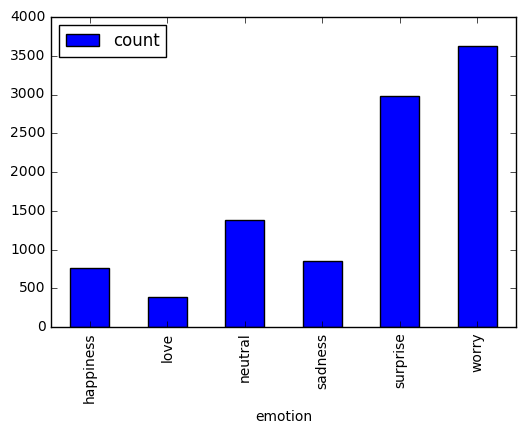

In [53]:
grouped_emotion_messages.plot.bar()

## Considering the dataset is extremely out of sample in regards to training data, there's no way this emotion classifier is accurate.

These results do seem semi logical though, based on some knowledge of the group.  Online trolls are well known for their anger and rudeness, which could seemingly be classified as surprise and worry on a more standard data set.